In [2]:
!pip install torchcam

In [11]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def show_gradcam(model, image_path, target_layer, class_names):
    model.eval()

    # Preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Grad-CAM extraction
    cam_extractor = SmoothGradCAMpp(model, target_layer)

    out = model(input_tensor)
    pred_class = out.argmax(dim=1).item()
    cams = cam_extractor(pred_class, out)
    grayscale_cam = cams[0].squeeze().cpu()

    # Visualization
    heatmap = overlay_mask(img, transforms.ToPILImage()(grayscale_cam), alpha=0.5)
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.imshow(img); plt.title("Original")
    plt.subplot(1,2,2); plt.imshow(heatmap); plt.title(f"Grad-CAM → {class_names[pred_class]}")
    plt.show()


In [8]:
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])
test_dataset = ImageFolder(root="/content/drive/MyDrive/Research paper on cnn and ensemble learning/Dataset/Splitted_dataset/test", transform=val_test_transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
resnet34 = models.resnet34(pretrained = False)
resnet34.fc = nn.Linear(resnet34.fc.in_features, 7)
resnet34.load_state_dict(torch.load("/content/drive/MyDrive/Research paper on cnn and ensemble learning/Models/resnet34_best.pth", map_location=device))
resnet34.to(device).eval()

In [ ]:
resnet50 = models.resnet50(pretrained = False)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 7)
resnet50.load_state_dict(torch.load("/content/drive/MyDrive/Research paper on cnn and ensemble learning/Models/resnet50_best.pth", map_location=device))
resnet50.to(device).eval()

In [ ]:
effnet = models.efficientnet_b0(pretrained=False)
effnet.classifier[1] = nn.Linear(effnet.classifier[1].in_features, 7)
effnet.load_state_dict(torch.load("/content/drive/MyDrive/Research paper on cnn and ensemble learning/Models/efficientnet_b0_best.pth", map_location=device))
effnet.to(device).eval()

In [16]:
class_names = test_dataset.classes

img_path = "/content/drive/MyDrive/Research paper on cnn and ensemble learning/Dataset/Splitted_dataset/test/mel/ISIC_0024700.jpg"

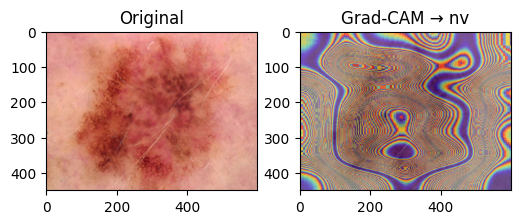

AttributeError: 'SmoothGradCAMpp' object has no attribute 'clear_hooks'

In [19]:
show_gradcam(resnet34, img_path, target_layer='layer4', class_names=class_names)

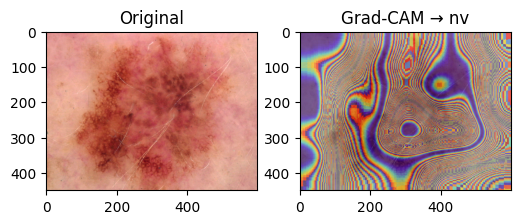

AttributeError: 'SmoothGradCAMpp' object has no attribute 'clear_hooks'

In [20]:
show_gradcam(resnet50, img_path, target_layer='layer4', class_names=class_names)

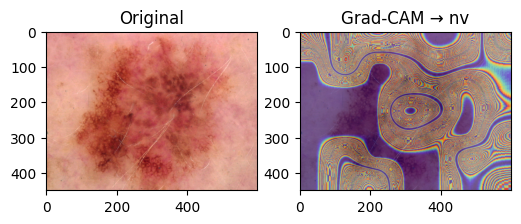

AttributeError: 'SmoothGradCAMpp' object has no attribute 'clear_hooks'

In [21]:
show_gradcam(effnet, img_path, target_layer='features.6', class_names=class_names)

In [23]:
def ensemble_gradcam(img_path, models, weights, layers, class_names):
    img = Image.open(img_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225])
    ])
    input_tensor = transform(img).unsqueeze(0).to(device)

    cams, preds = [], []
    for model, layer in zip(models, layers):
        cam_extractor = SmoothGradCAMpp(model, layer)
        out = model(input_tensor)
        preds.append(out.softmax(dim=1))
        pred_class = out.argmax(dim=1).item()
        cams.append(cam_extractor(pred_class, out)[0].squeeze().cpu())
        cam_extractor.clear_hooks()

    # weighted average of cams
    ensemble_cam = sum(w*c for w, c in zip(weights, cams))
    heatmap = overlay_mask(img, transforms.ToPILImage()(ensemble_cam), alpha=0.5)

    # weighted prediction
    weighted_pred = sum(w*p for w, p in zip(weights, preds))
    pred_idx = weighted_pred.argmax(dim=1).item()

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.imshow(img); plt.title("Original")
    plt.subplot(1,2,2); plt.imshow(heatmap); plt.title(f"Ensemble → {class_names[pred_idx]}")
    plt.show()


In [ ]:
import

In [24]:
ensemble_gradcam(img_path,
                 models=[resnet34, resnet50, effnet],
                 weights=weights,
                 layers=['layer4','layer4','features.6'],
                 class_names=class_names)

NameError: name 'weights' is not defined